# Exploring Hypothesis Testing: A Series for Beginners

## 2. Data Understanding


In [39]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### 2.2 Data description

In [4]:
df = pd.read_csv("bestsellers with categories.csv")
df.head(30)

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction
5,A Dance with Dragons (A Song of Ice and Fire),George R. R. Martin,4.4,12643,11,2011,Fiction
6,A Game of Thrones / A Clash of Kings / A Storm...,George R. R. Martin,4.7,19735,30,2014,Fiction
7,A Gentleman in Moscow: A Novel,Amor Towles,4.7,19699,15,2017,Fiction
8,"A Higher Loyalty: Truth, Lies, and Leadership",James Comey,4.7,5983,3,2018,Non Fiction
9,A Man Called Ove: A Novel,Fredrik Backman,4.6,23848,8,2016,Fiction


- Name
  - Título del libro
  - Unidad: texto (categoría)
- Author
  - Nombre del autor
  - Unidad: texto (categoría)
- User Rating
  - Calificación promedio del libro por los usuarios
  - Unidad: número entre 0 y 5 (con decimales)
- Reviews
  - Número de reseñas
  - Unidad: número entero
- Price
  - Precio del libro
  - Unidad: número entero
- Year
  - Año en el que el libro fue de los más vendidos
  - Unidad: año (número entero)
- Genre
  - Género del libro simplificado (Fiction o Non Fiction)
  - Unidad: categorico con dos valores posibles

## 3. Data preparation


### 3.1 Typecasting

## 1. Business Understanding

dataset source: https://www.kaggle.com/datasets/sootersaalu/amazon-top-50-bestselling-books-2009-2019/data

### Context
Datos sobre los 50 libros más vendidos en Amazon de 2009 a 2019. 

### Hypothesis to Test

Vamos a responder a las siguientes preguntas con validez estadística:

- ¿Los géneros difieren en User Rating?
- ¿Los géneros difieren en número de Reviews?
- ¿Los géneros difieren en términos de precio?

In [5]:
# comprobamos el tipo de datos de las columnas
df.dtypes

Name            object
Author          object
User Rating    float64
Reviews          int64
Price            int64
Year             int64
Genre           object
dtype: object

In [6]:
columnas_categoricas = ["Genre", "Name", "Author"]
df[columnas_categoricas] = df[columnas_categoricas].astype("category")

In [7]:
df.dtypes

Name           category
Author         category
User Rating     float64
Reviews           int64
Price             int64
Year              int64
Genre          category
dtype: object

### 3.2 Handling Duplicates

Comprobar si hay autores o títulos iguales pero escritos diferente.

In [8]:
from fuzzywuzzy import fuzz


# Función para encontrar nombres de autores similares
def encontrar_similares(df, columna):
    autores = df[columna].unique()
    duplicados = []

    for i, autor1 in enumerate(autores):
        for autor2 in autores[i + 1 :]:
            ratio = fuzz.ratio(autor1, autor2)
            if ratio > 90:  # Puedes ajustar este umbral según tu criterio
                duplicados.append((autor1, autor2))

    return duplicados

In [9]:
# Encuentra nombres de autores similares
duplicados = encontrar_similares(df, "Author")

print(
    "Nombres de autores que se refieren al mismo autor pero están escritos diferente:"
)
for dup in duplicados:
    print(dup)

Nombres de autores que se refieren al mismo autor pero están escritos diferente:
('George R. R. Martin', 'George R.R. Martin')
('J.K. Rowling', 'J. K. Rowling')


In [10]:
# Replace the names of the Authors with the correct ones
df = df.replace("George R. R. Martin", "George R.R. Martin")
df = df.replace("J. K. Rowling", "J.K. Rowling")

In [11]:
# Encuentra nombres de títulos similares
duplicados = encontrar_similares(df, "Name")

print(
    "Nombres de autores que se refieren al mismo autor pero están escritos diferente:"
)
for dup in duplicados:
    print(dup)

Nombres de autores que se refieren al mismo autor pero están escritos diferente:
('The 5 Love Languages: The Secret to Love That Lasts', 'The 5 Love Languages: The Secret to Love that Lasts')
('The Girl Who Played with Fire (Millennium Series)', 'The Girl Who Played with Fire (Millennium)')


In [12]:
# Replace the names of the Authors with the correct ones
df = df.replace(
    "The 5 Love Languages: The Secret to Love That Lasts",
    "The 5 Love Languages: The Secret to Love that Lasts",
)
df = df.replace(
    "The Girl Who Played with Fire (Millennium Series)",
    "The Girl Who Played with Fire (Millennium)",
)

In [13]:
df

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction
...,...,...,...,...,...,...,...
545,Wrecking Ball (Diary of a Wimpy Kid Book 14),Jeff Kinney,4.9,9413,8,2019,Fiction
546,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2016,Non Fiction
547,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2017,Non Fiction
548,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2018,Non Fiction


In [14]:
# número de filas duplicadas
df.duplicated().sum()

0

Es normal no encontrar duplicados en este caso, hay libros que se repiten pero es imposible que coincidan en "Year". No es un error por si mismo. Pero hay un problema. Las "Reviews" deberían ser las que el libro tenia el año en el que fue de los mas vendidos. En lugar de eso son las del último año. Esto puede deberse a que el autor del dataset no tuvo acceso al historial de las reseñas.

Es importante tener en cuenta esto para el análisis.

Vamos a utilizar unicamente la muestra más reciente de cada libro.

In [15]:
# todos los libros con el titulo repetido
df[df.duplicated("Name")].head(20)

,Name,Author,User Rating,Reviews,Price,Year,Genre
10,A Man Called Ove: A Novel,Fredrik Backman,4.6,23848,8,2017,Fiction
21,All the Light We Cannot See,Anthony Doerr,4.6,36348,14,2015,Fiction
33,Becoming,Michelle Obama,4.8,61133,11,2019,Non Fiction
36,Between the World and Me,Ta-Nehisi Coates,4.7,10070,13,2016,Non Fiction
41,"Brown Bear, Brown Bear, What Do You See?",Bill Martin Jr.,4.9,14344,5,2019,Fiction
47,Catching Fire (The Hunger Games),Suzanne Collins,4.7,22614,11,2011,Fiction
48,Catching Fire (The Hunger Games),Suzanne Collins,4.7,22614,11,2012,Fiction
51,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14,2010,Non Fiction
52,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14,2011,Non Fiction
57,Cutting for Stone,Abraham Verghese,4.6,4866,11,2011,Fiction


In [16]:
# Drop duplicates
bestsellers = df.drop_duplicates(subset="Name", keep="last")
bestsellers

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction
...,...,...,...,...,...,...,...
538,Winter of the World: Book Two of the Century T...,Ken Follett,4.5,10760,15,2012,Fiction
539,Women Food and God: An Unexpected Path to Almo...,Geneen Roth,4.2,1302,11,2010,Non Fiction
544,Wonder,R. J. Palacio,4.8,21625,9,2017,Fiction
545,Wrecking Ball (Diary of a Wimpy Kid Book 14),Jeff Kinney,4.9,9413,8,2019,Fiction


Resumen:
- Hemos corregido los errores ortográficos de los títulos y autores.
- Hemos seleccionado las muestras más recientes de cada libro.

Hemos reducido el tamaño del dataset de 550 a 349 muestras.

### 3.3 Outlier Analysis

#### 3.3.2 Usando boxplot y IQR 
IQR: El rango intercuartil (IQR) es la diferencia entre el tercer cuartil (Q3) y el primer cuartil (Q1). Los valores que caen por debajo de Q1 - 1.5 * IQR o por encima de Q3 + 1.5 * IQR se consideran outliers.

Los valores fuera del de este rango, son los que se representa como puntos en los bloxpots.


In [17]:
import plotly.express as px

selected_columns = ["Reviews", "Price"]

for column in selected_columns:
    fig = px.box(df, x=column, title=f"Boxplot of {column}")
    fig.update_layout(title_x=0.5)  # Centra el título
    fig.show()

Observaciones:

- age: no se detectan outliers
- BMI: existen outliers, personas con una alta obesidad
- charges: existen outliers, personas con cargos muy altos al seguro


### 3.4 Zero & Near Zero Variance Features


In [18]:
bestsellers.describe()

,User Rating,Reviews,Price,Year
count,349.000000,349.000000,349.000000,349.000000
mean,4.608596,9811.922636,12.962751,2014.128940
std,0.227266,10899.783863,10.011562,3.377239
min,3.300000,37.000000,0.000000,2009.000000
25%,4.500000,3428.000000,8.000000,2011.000000
50%,4.600000,6310.000000,11.000000,2014.000000
75%,4.800000,11550.000000,16.000000,2017.000000
max,4.900000,87841.000000,105.000000,2019.000000


Variables númericas

In [19]:
selected_columns = ["User Rating", "Reviews", "Price"]

# Calcular la varianza de cada columna
variances = bestsellers[selected_columns].var()

# Definir un umbral para la varianza
threshold = 0.1

# Identificar las columnas con varianza cercana a cero o muy pequeña
zero_variance_cols = variances[variances <= threshold].index

print("Columnas con Zero & Near Zero Variance:")
print(zero_variance_cols)

Columnas con Zero & Near Zero Variance:
Index(['User Rating'], dtype='object')


Variables categoricas. No tiene sentido en este analisis en este caso.

Observiaciones:

- No se detectan variables con Zero & Near Zero Variance

### 3.5 Missing values


In [20]:
bestsellers.isnull().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

Observiaciones:

- No hay Missing values

# 4. Hipothesis Testing

Vamos a responder a las siguientes preguntas con validez estadística:
- ¿Los géneros difieren en User Rating?
- ¿Los géneros difieren en número de Reviews?
- ¿Los géneros difieren en términos de precio?

## ¿Los géneros difieren en User Rating?

Vamos a crear una variable para cada grupo de interes y representarlos gráficamente.

In [42]:
fiction_bestsellers = bestsellers[bestsellers["Genre"] == "Fiction"]
nonfiction_bestsellers = bestsellers[bestsellers["Genre"] == "Non Fiction"]

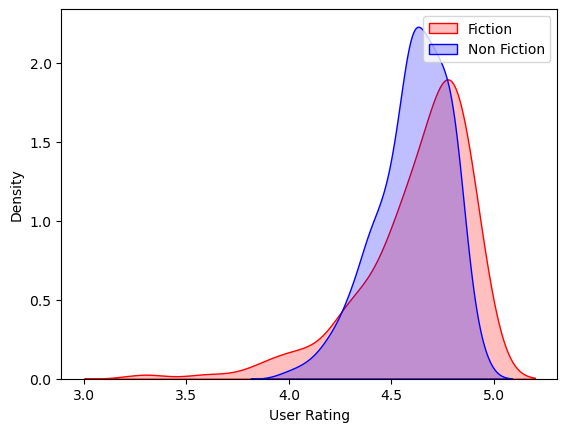

In [43]:
sns.kdeplot(fiction_bestsellers["User Rating"], fill=True, color="r")
sns.kdeplot(nonfiction_bestsellers["User Rating"], fill=True, color="b")
plt.legend(["Fiction", "Non Fiction"])
plt.xlabel("User Rating")
plt.ylabel("Density")
plt.show()

In [41]:
# Calcular el coeficiente de asimetría
skewness = stats.skew(bestsellers["User Rating"])
print("Coeficiente de asimetría:", skewness)

if skewness > 0:
    print("La distribución está positivamente sesgada.")
elif skewness < 0:
    print("La distribución está negativamente sesgada.")
else:
    print("La distribución es simétrica.")

Coeficiente de asimetría: -1.521358275451138
La distribución está negativamente sesgada.


Número de observaciones para cada grupo:

In [44]:
bestsellers["Genre"].value_counts()

Genre
Non Fiction    190
Fiction        159
Name: count, dtype: int64

Realizamos un test de normalidad para cada grupo:

In [54]:
from scipy import stats


def shapiro_test(data, alpha=0.05):
    """
    Realiza la prueba de Shapiro-Wilk para verificar la normalidad de los datos.

    Parameters:
    data (array-like): Los datos a analizar.
    alpha (float): Nivel de significancia.

    Returns:
    str: El resultado de la prueba.
    """
    statistic, p_value = stats.shapiro(data)

    if p_value < alpha:
        return (
            "Rechazamos la hipótesis nula. Los datos no siguen una distribución normal."
        )
    else:
        return "Fallamos al rechazar la hipótesis nula. Los datos pueden considerarse normalmente distribuidos."


result_fiction = shapiro_test(fiction_bestsellers["User Rating"])
result_nonfiction = shapiro_test(nonfiction_bestsellers["User Rating"])

print("Para bestsellers de ficción:", result_fiction)
print("Para bestsellers de no ficción:", result_nonfiction)

Para bestsellers de ficción: Rechazamos la hipótesis nula. Los datos no siguen una distribución normal.
Para bestsellers de no ficción: Rechazamos la hipótesis nula. Los datos no siguen una distribución normal.


Estudiemos la relación entre las varianzas de cada grupo.

In [71]:
# Realiza el Test de Levene
statistic, p_value = stats.levene(
    fiction_bestsellers["User Rating"], nonfiction_bestsellers["User Rating"]
)

# Nivel de significancia
alpha = 0.05

# Comprueba la significancia
if p_value < alpha:
    print("Rechazamos la hipótesis nula. Las varianzas no son similares")
else:
    print("Fallamos al rechazar la hipótesis nula. Las varianzas son similares")

Rechazamos la hipótesis nula. Las varianzas no son similares


In [70]:
# varianza de los grupos
bestsellers.groupby(["Genre"])["User Rating"].var()

Genre
Fiction        0.075720
Non Fiction    0.031736
Name: User Rating, dtype: float64

### 1. Seleccionamos la hipotesis y el nivel de significancia

H0: El "User Rating" de los libros de ficción es igual que el de los libros de no ficción

Ha: El "User Rating" de los libros de ficción es diferente que el de los libros de no ficción

alpha = 0.05

### 2. Identificamos el tipo de test

Deseamos comparar las medias de dos grupos de nuestra Sample. Por lo que un 2-Sample t-Test parece lo adecuado. Lo primero es ver si se cumplen los requisitos del test.

#### 2.1 Requisitos del test
[Book:Hypothesis Testing An Intuitive Guide For Making Data Driven Decisions
Page: 48
Section: 2-Sample t-Tests]
- Tenemos un Sample representativo de la población? Si.
- Los datos son continuos? 
  - En este contexto, los "User Rating" que van de 0 a 5 con un único decimal pueden considerarse como datos continuos. Sim embargo, observando las gráficas, vemos que la mayoría de los valores se encuetran en un intervalor muy pequeño (mayores a 4.0). Esto dificulta el poder considerarlo continuos.
- Las muestras siguen una distribución normal o hay más de 15 observaciones
  - No, las muestras no siguen una distribución normal. Pero hay más de 15 observaciones en cada grupo, gracias al teorema del límite central podemos renunciar al supuesto de normalidad.
- Los grupos son independientes? Si.
- Las varianzas son iguales (o al menos similares)?
  - No.


Por la falta de continuidad en los datos, vamos a realizar un **test no paramétrico Mann-Whitney**.

[Book:Hypothesis Testing An Intuitive Guide For Making Data Driven Decisions
Page: 341
Section: Analyzing Likert Scale Data]

Para realizar el test vamos a usar [scipy.stats.mannwhitneyu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)

In [56]:
# Realiza el test de Mann-Whitney
statistic, p_value = stats.mannwhitneyu(
    nonfiction_bestsellers["User Rating"], fiction_bestsellers["User Rating"]
)

# Imprime los resultados
print("Valor p:", p_value)

# Comprueba la significancia
alpha = 0.05  # Nivel de significancia
if p_value < alpha:
    print(
        "Rechazamos la hipótesis nula. Hay diferencias significativas entre los grupos."
    )
else:
    print(
        "Fallamos al rechazar la hipótesis nula. No hay diferencias significativas entre los grupos."
    )

Valor p: 0.019840907319029977
Rechazamos la hipótesis nula. Hay diferencias significativas entre los grupos.


## ¿Los géneros difieren en número de Reviews?

Representamos gráficamente los grupos de interés.

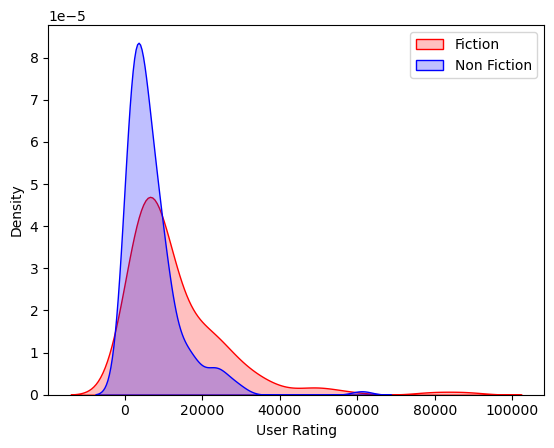

In [31]:
sns.kdeplot(fiction_bestsellers["Reviews"], fill=True, color="r")
sns.kdeplot(nonfiction_bestsellers["Reviews"], fill=True, color="b")
plt.legend(["Fiction", "Non Fiction"])
plt.xlabel("User Rating")
plt.ylabel("Density")
plt.show()

In [64]:
# Calcular el coeficiente de asimetría
skewness = stats.skew(bestsellers["Reviews"])
print("Coeficiente de asimetría:", skewness)

if skewness > 0:
    print("La distribución está positivamente sesgada.")
elif skewness < 0:
    print("La distribución está negativamente sesgada.")
else:
    print("La distribución es simétrica.")

Coeficiente de asimetría: 3.119812029552558
La distribución está positivamente sesgada.


Número de observaciones para cada grupo:

In [ ]:
bestsellers["Genre"].value_counts()

Genre
Non Fiction    190
Fiction        159
Name: count, dtype: int64

Realizamos un test de normalidad para cada grupo:

In [65]:
from scipy import stats


def shapiro_test(data, alpha=0.05):
    """
    Realiza la prueba de Shapiro-Wilk para verificar la normalidad de los datos.

    Parameters:
    data (array-like): Los datos a analizar.
    alpha (float): Nivel de significancia.

    Returns:
    str: El resultado de la prueba.
    """
    statistic, p_value = stats.shapiro(data)

    if p_value < alpha:
        return (
            "Rechazamos la hipótesis nula. Los datos no siguen una distribución normal."
        )
    else:
        return "Fallamos al rechazar la hipótesis nula. Los datos pueden considerarse normalmente distribuidos."


result_fiction = shapiro_test(fiction_bestsellers["Reviews"])
result_nonfiction = shapiro_test(nonfiction_bestsellers["Reviews"])

print("Para bestsellers de ficción:", result_fiction)
print("Para bestsellers de no ficción:", result_nonfiction)

Para bestsellers de ficción: Rechazamos la hipótesis nula. Los datos no siguen una distribución normal.
Para bestsellers de no ficción: Rechazamos la hipótesis nula. Los datos no siguen una distribución normal.


Estudiemos la relación entre las varianzas de cada grupo.

In [66]:
# varianza de los grupos
bestsellers.groupby(["Genre"])["Reviews"].var()

Genre
Fiction        1.781185e+08
Non Fiction    5.265203e+07
Name: Reviews, dtype: float64

In [67]:
# Realiza el Test de Levene
statistic, p_value = stats.levene(
    fiction_bestsellers["User Rating"], nonfiction_bestsellers["User Rating"]
)

# Nivel de significancia
alpha = 0.05

# Comprueba la significancia
if p_value < alpha:
    print("Rechazamos la hipótesis nula. Las varianzas no son similares")
else:
    print("Fallamos al rechazar la hipótesis nula. Las varianzas son similares")

Rechazamos la hipótesis nula. Las varianzas son diferentes


### 1. Seleccionamos la hipotesis y el nivel de significancia

H0: El número de Reviews medio de los libros de ficción es igual que el de los libros de no ficción

Ha: El número de Reviews medio de los libros de ficción es diferente que el de los libros de no ficción

alpha = 0.05

### 2. Identificamos el tipo de test

Deseamos comparar las medias de dos grupos de nuestra Sample. Por lo que un 2-Sample t-Test parece lo adecuado. Lo primero es ver si se cumplen los requisitos del test.

#### 2.1 Requisitos del test
[Book:Hypothesis Testing An Intuitive Guide For Making Data Driven Decisions
Page: 48
Section: 2-Sample t-Tests]
- Tenemos un Sample representativo de la población? Si.
- Los datos son continuos? Si.
- Las muestras siguen una distribución normal o hay más de 15 observaciones
  - No, las muestras no siguen una distribución normal. Pero hay más de 15 observaciones en cada grupo, gracias al teorema del límite central podemos renunciar al supuesto de normalidad.
- Los grupos son independientes? Si.
- Las varianzas son iguales (o al menos similares)?
  - No.


Las varianzas no son similares y su relación es de más del doble. Vamos a reliazar un test tipo **Welch's t-test**.

Para realizar el test vamos a usar [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html).
Para realizar este test, es necesario definir el parametro *equal_varbool* como *False*.

In [68]:
# Realiza el test t de Welch (equal_var=False)
statistic, p_value = stats.ttest_ind(
    nonfiction_bestsellers["Reviews"], fiction_bestsellers["Reviews"], equal_var=False
)

# Imprime los resultados
print("Valor p:", p_value)

# Comprueba la significancia
alpha = 0.05  # Nivel de significancia
if p_value < alpha:
    print(
        "Rechazamos la hipótesis nula: Hay diferencias significativas entre los grupos."
    )
else:
    print(
        "No podemos rechazar la hipótesis nula: No hay diferencias significativas entre los grupos."
    )

Valor p: 4.7012426165976585e-07
Rechazamos la hipótesis nula: Hay diferencias significativas entre los grupos.


Los libros del género de ficción obtienen más Reviews que los libros de no ficción.

## ¿Los géneros difieren en términos de Price?

Representamos gráficamente los datos.

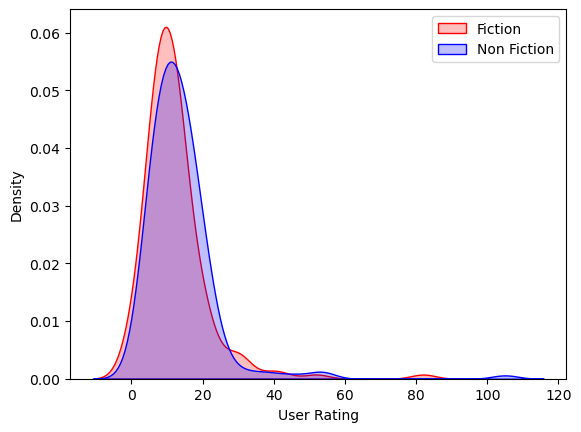

In [36]:
sns.kdeplot(fiction_bestsellers["Price"], fill=True, color="r")
sns.kdeplot(nonfiction_bestsellers["Price"], fill=True, color="b")
plt.legend(["Fiction", "Non Fiction"])
plt.xlabel("User Rating")
plt.ylabel("Density")
plt.show()

In [59]:
# Calcular el coeficiente de asimetría
skewness = stats.skew(bestsellers["Price"])
print("Coeficiente de asimetría:", skewness)

if skewness > 0:
    print("La distribución está positivamente sesgada.")
elif skewness < 0:
    print("La distribución está negativamente sesgada.")
else:
    print("La distribución es simétrica.")

Coeficiente de asimetría: 4.059768474746167
La distribución está positivamente sesgada.


Realizamos un test de normalidad para cada grupo:

In [61]:
from scipy import stats


def shapiro_test(data, alpha=0.05):
    """
    Realiza la prueba de Shapiro-Wilk para verificar la normalidad de los datos.

    Parameters:
    data (array-like): Los datos a analizar.
    alpha (float): Nivel de significancia.

    Returns:
    str: El resultado de la prueba.
    """
    statistic, p_value = stats.shapiro(data)

    if p_value < alpha:
        return (
            "Rechazamos la hipótesis nula. Los datos no siguen una distribución normal."
        )
    else:
        return "Fallamos al rechazar la hipótesis nula. Los datos pueden considerarse normalmente distribuidos."


result_fiction = shapiro_test(fiction_bestsellers["Price"])
result_nonfiction = shapiro_test(nonfiction_bestsellers["Price"])

print("Para bestsellers de ficción:", result_fiction)
print("Para bestsellers de no ficción:", result_nonfiction)

Para bestsellers de ficción: Rechazamos la hipótesis nula. Los datos no siguen una distribución normal.
Para bestsellers de no ficción: Rechazamos la hipótesis nula. Los datos no siguen una distribución normal.


Estudiemos la relación entre las varianzas de cada grupo.

In [74]:
# Realiza el Test de Levene
statistic, p_value = stats.levene(
    fiction_bestsellers["Price"], nonfiction_bestsellers["Price"]
)

# Nivel de significancia
alpha = 0.05

# Comprueba la significancia
if p_value < alpha:
    print("Rechazamos la hipótesis nula. Las varianzas no son similares")
else:
    print("Fallamos al rechazar la hipótesis nula. Las varianzas son similares")

Fallamos al rechazar la hipótesis nula. Las varianzas son similares


In [75]:
# varianza de los grupos
bestsellers.groupby(["Genre"])["Price"].var()

Genre
Fiction         91.521376
Non Fiction    107.024673
Name: Price, dtype: float64

### 1. Seleccionamos la hipotesis y el nivel de significancia

H0: El precio medio de los libros de ficción es igual que el de los libros de no ficción

Ha: El precio medio de los libros de ficción es diferente que el de los libros de no ficción

alpha = 0.05

### 2. Identificamos el tipo de test

Deseamos comparar las medias de dos grupos de nuestra Sample. Por lo que un 2-Sample t-Test parece lo adecuado. Lo primero es ver si se cumplen los requisitos del test.

#### 2.1 Requisitos del test
[Book:Hypothesis Testing An Intuitive Guide For Making Data Driven Decisions
Page: 48
Section: 2-Sample t-Tests]
- Tenemos un Sample representativo de la población? Si.
- Los datos son continuos? Si.
- Las muestras siguen una distribución normal o hay más de 15 observaciones
  - No, las muestras no siguen una distribución normal. Pero hay más de 15 observaciones en cada grupo, gracias al teorema del límite central podemos renunciar al supuesto de normalidad.
- Los grupos son independientes? Si.
- Las varianzas son iguales (o al menos similares)? Si.

Se cumplen los requisitos para realizar un **2-Sample t-Test**.

Para realizar el test vamos a usar [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html).

In [76]:
# Realiza el test t
statistic, p_value = stats.ttest_ind(
    nonfiction_bestsellers["Price"], fiction_bestsellers["Price"]
)

# Imprime los resultados
print("Valor p:", p_value)

# Comprueba la significancia
alpha = 0.05  # Nivel de significancia
if p_value < alpha:
    print(
        "Rechazamos la hipótesis nula: Hay diferencias significativas entre los grupos."
    )
else:
    print(
        "No podemos rechazar la hipótesis nula: No hay diferencias significativas entre los grupos."
    )

Valor p: 0.16615124881617802
No podemos rechazar la hipótesis nula: No hay diferencias significativas entre los grupos.


El precio no es dependiente del género.